/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


UMPM
elapsed: 85.09269165992737
elapsed: 85.1007387638092
elapsed: 85.38128352165222
elapsed: 85.40615677833557
[GRAPHCUT] step1 elapsed: 1.3377666473388672
[GRAPHCUT] step2 elapsed: 0.024083852767944336
[GRAPHCUT] step3 elapsed: 0.009340524673461914
[GRAPHCUT] step4 elapsed: 13.443906784057617
-------------------------------------------
Handle transitivity:
	Intra:		 352
	Intra(choice):	 14
	Inter:		 3198
	Inter(choice):	 366
-------------------------------------------
	Time =  2200  ms
	result: 0

	Total cost: 1463.4086066759826

# valid points:		 160
# invalid points:	 31

-------------------------------------------
	Nu:	 191
	Iota:	 305
	Lambda:	 796
-------------------------------------------


#persons: 6
[GRAPHCUT] step5 elapsed 2.2126712799072266
elapsed 17.0456326007843


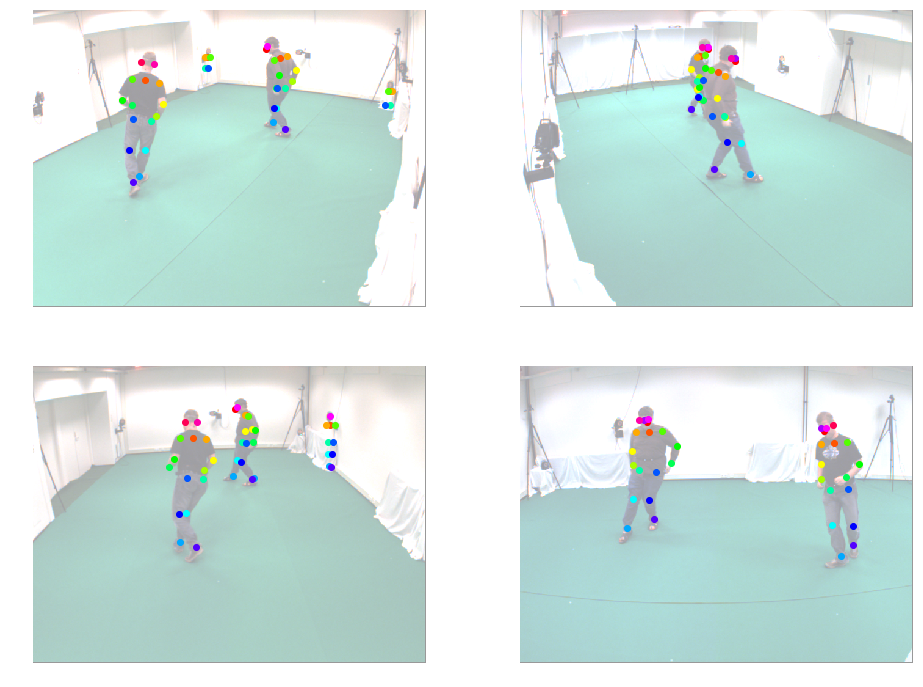

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../../settings.txt'))
print('\n')
# ------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os.path import isfile
import sys
from time import time
import cv2
import numpy as np
from os.path import join, isdir
sys.path.insert(0,'../../../easy_multi_person_pose_estimation')
sys.path.insert(0,'../../')
import mvpose.data.transform as tfm
import mvpose.geometry.geometry as gm
from mvpose.geometry import stereo
import mvpose.pose_estimation.heatmaps as mvhm
from mvpose.candidates import peaks as mvpeaks
import mvpose.pose_estimation.part_affinity_fields as mvpafs
from mvpose.data.default_limbs import  DEFAULT_LIMB_SEQ, DEFAULT_SENSIBLE_LIMB_LENGTH, DEFAULT_MAP_IDX
from mvpose.algorithm import graphcut
from cselect import color as cs

from poseestimation import model
pe = model.PoseEstimator()


USE_UMPM = True

if USE_UMPM:
    root = join(Settings['data_root'], 'pak')
    from pak.datasets.UMPM import UMPM
    user = Settings['UMPM']['username']
    pwd = Settings['UMPM']['password']
    
    X, Y, Calib = tfm.get_from_umpm(root, 'p2_free_1', user, pwd)
    Human_Pose_Gt = Y

    # interesting frames: [340, 215, 250]
    # last one: 450
    FRAME = 450

    Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])
    with_gpu = False

    if with_gpu:
        _start = time()
        heatmaps, pafs = pe.predict_pafs_and_heatmaps(I)
        _end = time(); print('elapsed:', _end - _start)
    else:
        hm_file = '/tmp/heatmaps' + str(FRAME) + '.npy'
        paf_file = '/tmp/pafs' + str(FRAME) + '.npy'

        if isfile(hm_file) and isfile(paf_file):
            heatmaps = np.load(hm_file)
            pafs = np.load(paf_file)
        else:
            heatmaps = []; pafs = []
            for im in Im:
                _start = time()
                hm, paf = pe.predict_pafs_and_heatmaps(im)
                heatmaps.append(np.squeeze(hm))
                pafs.append(np.squeeze(paf))
                _end = time()
                print('elapsed:', _end - _start)
            heatmaps = np.array(heatmaps)
            pafs = np.array(pafs)
            np.save(hm_file, heatmaps)
            np.save(paf_file, pafs)
else:  # use CMU
    root = Settings['CMU']['data_root']
    
    FRAME = 2000
    
    panels = [1, 5,  6,  9, 10, 14, 15, 16, 18, 19]
    nodes = [ 1, 8, 15, 12,  6,  3, 12, 12, 13, 14]
    
    panels = [1,  6, 10, 14, 15, 18, 5]
    nodes = [ 1, 15,  6,  3, 12, 13, 8]
    
    seq_name = '160422_ultimatum1'
    
    Im, Y, Calib = tfm.get_from_cmu_panoptic(root, seq_name, 
                                            panels, nodes, 
                                            frame=FRAME)
    print("Im:", Im.shape)
    print("Calib:", len(Calib))
    
    hm_file = '/tmp/cmu_heatmaps' + str(FRAME) + '.npy'
    paf_file = '/tmp/cmu_pafs' + str(FRAME) + '.npy'

    if isfile(hm_file) and isfile(paf_file):
        heatmaps = np.load(hm_file)
        pafs = np.load(paf_file)
    else:
        heatmaps = []; pafs = []
        for im in Im:
            _start = time()
            hm, paf = pe.predict_pafs_and_heatmaps(im)
            heatmaps.append(np.squeeze(hm))
            pafs.append(np.squeeze(paf))
            _end = time()
            print('elapsed:', _end - _start)
        heatmaps = np.array(heatmaps)
        pafs = np.array(pafs)
        np.save(hm_file, heatmaps)
        np.save(paf_file, pafs)
        
import mvpose.plot.limbs as pltlimbs

colors = cs.lincolor(19)/255

mm_transform = 1 if USE_UMPM else 10  # CMU uses cm, not mm!!

r = 1
_start = time()
Gr = graphcut.GraphCutSolver(heatmaps, pafs, Calib, r, debug=True,
                            sensible_limb_length=DEFAULT_SENSIBLE_LIMB_LENGTH/mm_transform)
_end = time()
print('elapsed', _end - _start)

fig = plt.figure(figsize=(16,12))

for idx, im in enumerate(Im):
    ax = fig.add_subplot(2 if USE_UMPM else 3,2 if USE_UMPM else 3,idx+1)
    ax.imshow(im, alpha=0.4)
    ax.axis('off')
    
    for jid in range(Gr.peaks2d[idx].n_joints):
        for x,y,score in Gr.peaks2d[idx][jid]:
            ax.scatter(x,y, color=colors[jid])
    
plt.show()

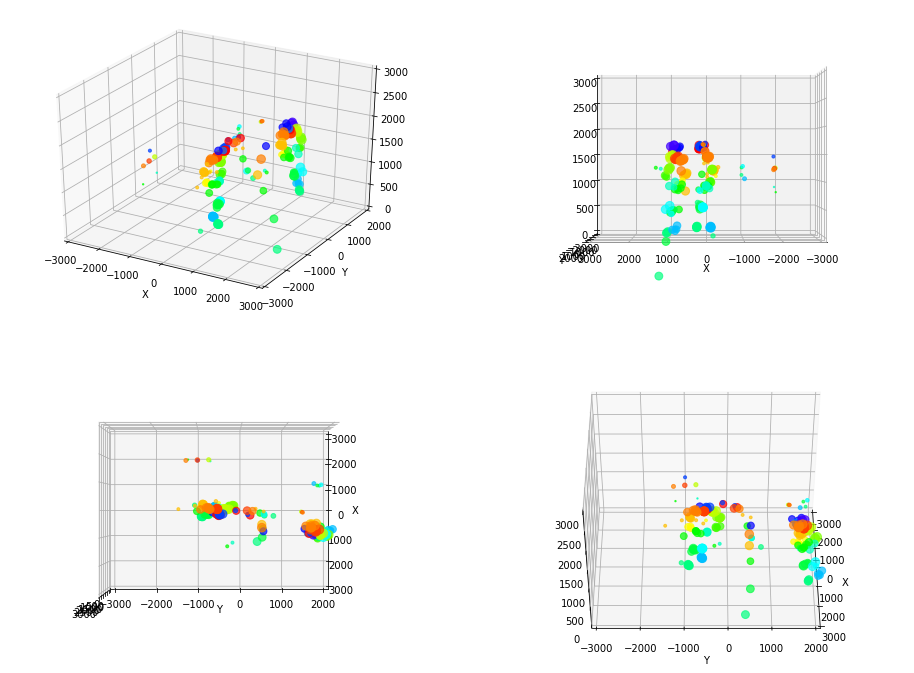

In [2]:
COLORS = cs.lincolor(25)/255
fig = plt.figure(figsize=(16,12))
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Points3d = Gr.peaks3d_weighted

def plot(ax):
    if USE_UMPM:
        ax.set_xlim([-3000, 3000])
        ax.set_ylim([-3000, 2000])
        ax.set_zlim([0, 3000])
    else:
        ax.set_xlim([-300, 300])
        ax.set_ylim([-300, 300])
        ax.set_zlim([-100, 300])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    for jid, pts3d in enumerate(Points3d):
        X = pts3d[:,0]
        Y = pts3d[:,1]
        Z = pts3d[:,2]
        W1 = pts3d[:,3]
        W2 = pts3d[:,4]

        ax.scatter(X,Y,Z,alpha=0.7, color=COLORS[jid], s=W1*W2*100)

ax = fig.add_subplot(221, projection='3d'); plot(ax)
ax = fig.add_subplot(222, projection='3d'); ax.view_init(0, 90); plot(ax)
ax = fig.add_subplot(223, projection='3d'); ax.view_init(90, 0); plot(ax)
ax = fig.add_subplot(224, projection='3d'); ax.view_init(45, 0); plot(ax)

plt.show()

In [3]:
from ortools.linear_solver import pywraplp as mip
from mvpose.geometry import geometry as gm
from mvpose.candidates.transitivity import TransitivityLookup
import networkx as nx

points3d = Gr.peaks3d_weighted
limbs3d = Gr.limbs3d

limbSeq = DEFAULT_LIMB_SEQ
sensible_limb_length = DEFAULT_SENSIBLE_LIMB_LENGTH

assert len(limbs3d) == len(limbSeq)
assert len(limbs3d) == len(sensible_limb_length)
n_joints = len(points3d)

_start = time()
# ===========================================
# PARAMETERS
# ===========================================
max_radius = 300
radius = 50
iota_scale = 1
min_nbr_joints = 8

# ===========================================
# COST  FUNCTIONS
# ===========================================
pboost_big = lambda x: np.log((x+1) / (2 * (0.5 * (-x -1)+1))) * 2
pboost_small = lambda x: np.log(x/(1-x))
func1 = lambda u: np.tanh(pboost_small(u))
func2 = lambda d: (-np.tanh((d-radius)/radius) * iota_scale)
func3 = lambda x: pboost_big(x)

# ===========================================
# CREATE COST AND BOOLEAN VARIABLES
# ===========================================
solver = mip.Solver('m', mip.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

D = []  # all nodes of the graph    (jid, a)
E_j = []  # all edges on the joints (jid, a, b)
E_l = []  # all edges on the limbs  (jid1, jid2, a, b)

Nu = {}
Iota = {}
Lambda = {}
Get_Iota = lambda jid, a, b: Iota[jid, min(a, b), max(a, b)]
Get_Lambda = lambda jid1, jid2, a, b: Lambda[jid1, jid2, a, b] \
    if (jid1, jid2, a, b) in Lambda else Lambda[jid2, jid1, b, a]

DEBUG_Nu = []
DEBUG_Iota = []
DEBUG_Lambda = []

Sum = []

for jid, pts3d in enumerate(points3d):
    # ===========================================
    # HANDLE NU
    # ===========================================
    left = pts3d[:,3]
    right = pts3d[:,4]
    unary = np.multiply(left, right)
    n = len(unary)
    for idx in range(n):
        Nu[jid, idx] = solver.BoolVar('nu[%i,%i]' % (jid, idx))
        D.append((jid, idx))
    
    s = solver.Sum(
        Nu[jid, idx] * func1(unary[idx]) for idx in range(n)
    )
    Sum.append(s)
    
    # *********************************************************
    for idx in range(n):
        DEBUG_Nu.append((jid, idx, func1(unary[idx])))
    # *********************************************************
    
    # ===========================================
    # HANDLE IOTA
    # ===========================================
    # (a, b, distance)
    distance = gm.calculate_distance_all4all(
        points3d[jid], points3d[jid], max_distance=max_radius,
        AB_are_the_same=True)
    As = distance[:,0].astype('int32')
    Bs = distance[:,1].astype('int32')
    
    for a, b in zip(As, Bs):
        Iota[jid, a, b] = solver.BoolVar('j[%i,%i,%i]' % (jid, a, b))
        E_j.append((jid, a, b))
    
    s = solver.Sum(
        Iota[jid, int(a), int(b)] * func2(d) for a,b,d in distance
    )
    Sum.append(s)
    
    # *********************************************************
    for a,b,d in distance:
        DEBUG_Iota.append((jid, int(a), int(b), func2(d)))
    # *********************************************************

# ===========================================
# HANDLE LAMBDA
# ===========================================
for lid, ((jid1,jid2), (mindist, maxdist)) in \
        enumerate(zip(limbSeq, sensible_limb_length)):
    assert jid1 != jid2
    ABdistance = gm.calculate_distance_all4all(
        points3d[jid1], points3d[jid2], max_distance=maxdist,
        min_distance=mindist,
        AB_are_the_same=False)
    As = ABdistance[:,0].astype('int32')
    Bs = ABdistance[:,1].astype('int32')
    distance = ABdistance[:,2]
    
    for a,b in zip(As, Bs):
        Lambda[jid1, jid2, a, b] = solver.BoolVar(
            'l[%i,%i,%i,%i]' % (jid1, jid2, a, b))
        E_l.append((jid1, jid2, a, b))
    
    W = limbs3d[lid]
    Scores = W[As,Bs]
  
    s = solver.Sum(
        Get_Lambda(jid1, jid2, a, b) * func3(s) for a,b,s in\
        zip(As, Bs, Scores))
    Sum.append(s)
    
    for a,b,s in zip(As, Bs, Scores):
        DEBUG_Lambda.append((jid1, jid2, a, b, pboost_big(s)))

# ===========================================
# ONLY CONSIDER VALID EDGES
# ===========================================
for jid1, jid2, a, b in E_l:
    solver.Add(
        Lambda[jid1, jid2, a, b] * 2 <= Nu[jid1, a] + Nu[jid2, b])

for jid, a, b in E_j:
    solver.Add(
        Iota[jid, a, b] * 2 <= Nu[jid, a] + Nu[jid, b])

# ===========================================
# HANDLE TRANSITIVITY CONSTRAINTS (1)
# ===========================================

Intra = []  #  [ (jid, a, b, c), ...]
Inter = []  # [ (jid1, a, b, jid2, c), ...]
Intra_choice = []  # [ (jid, a, b, c), ...]
Inter_choice = []  # [ (jid1, a, jid2, b, jid3, c), ...]

transitivity_lookup = TransitivityLookup(D, E_l, E_j)
for q in D:
    intra, intra_choice, inter, inter_choice =\
        transitivity_lookup.query_with_choice(*q)
    Intra += intra
    Inter += inter
    Intra_choice += intra_choice
    Inter_choice += inter_choice

assert len(Inter) == len(set(Inter))
assert len(Intra) == len(set(Intra))
assert len(Inter_choice) == len(set(Inter_choice))
assert len(Intra_choice) == len(set(Intra_choice))

print('-------------------------------------------')
print('Handle transitivity:')
print('\tIntra:\t\t', len(Intra))
print('\tIntra(choice):\t', len(Intra_choice))
print('\tInter:\t\t', len(Inter))
print('\tInter(choice):\t', len(Inter_choice))

# ===========================================
# HANDLE TRANSITIVITY CONSTRAINTS (2)
# ===========================================
for jid, a, b, c in Intra:
    assert a < b < c
    solver.Add(Get_Iota(jid, a, b) + Get_Iota(jid, a, c) - 1 <= \
        Get_Iota(jid, b, c))
    solver.Add(Get_Iota(jid, a, b) + Get_Iota(jid, b, c) - 1 <= \
        Get_Iota(jid, a, c))
    solver.Add(Get_Iota(jid, a, c) + Get_Iota(jid, b, c) - 1 <= \
        Get_Iota(jid, a, b))

for jid1, a, b, jid2, c in Inter:
    solver.Add(
        Get_Lambda(jid1, jid2, a, c) + Get_Lambda(jid1, jid2, b, c) -1 <= \
        Get_Iota(jid1, a, b))
    solver.Add(
        Get_Iota(jid1, a, b) + Get_Lambda(jid1, jid2, a, c) -1 <= \
        Get_Lambda(jid1, jid2, b, c))
    solver.Add(
        Get_Iota(jid1, a, b) + Get_Lambda(jid1, jid2, b, c) -1 <= \
        Get_Lambda(jid1, jid2, a, c))


# ===========================================
# HANDLE CHOICE CONSTRAINTS
# ===========================================
for jid, a, b, c in Intra_choice:  # either take { ab OR ac }
    solver.Add(
        Get_Iota(jid, a, b) + Get_Iota(jid, a, c) <= 1
    )

for jid1, a, jid2, b, jid3, c in Inter_choice:  # { ab OR ac }
    if jid1 == jid2:
        assert jid3 != jid1
        # if  [a]---[b]
        #     |
        #    (c)
        solver.Add(
            Get_Iota(jid1, a, b) + Get_Lambda(jid1, jid3, a, c) <= 1
        )
    elif jid2 == jid3:
        # if  [a]
        #     |   \
        #    (b)   (c)
        solver.Add(
            Get_Lambda(jid1, jid2, a, b) + Get_Lambda(jid1, jid3, a, c) <= 1
        )
    elif jid1 == jid3:
        # if  [a]---[c]
        #     |
        #    (b)
        solver.Add(
            Get_Lambda(jid1, jid2, a, b) + Get_Iota(jid1, a, c) <= 1
        )
    else:
        raise ValueError("nope")
    

# ===========================================
# SOLVE THE GRAPH
# ===========================================
solver.Maximize(solver.Sum(Sum))
RESULT = solver.Solve()
print('-------------------------------------------')
print("\tTime = ", solver.WallTime(), " ms")
print("\tresult:", RESULT)
print('\n\tTotal cost:', solver.Objective().Value())

# ===========================================
# EXTRACT INDIVIDUALS
# ===========================================

valid_3d_points = set()
count_invalid_points = 0
for (jid, idx), v in Nu.items():
    if v.solution_value() > 0:
        valid_3d_points.add((jid, idx))
    else:
        count_invalid_points += 1
print("\n# valid points:\t\t", len(valid_3d_points))
print("# invalid points:\t", count_invalid_points)

G = nx.Graph()
for (jid1, jid2, a, b), v in Lambda.items():
    if v.solution_value() > 0:
        assert (jid1, a) in valid_3d_points and (jid2, b) in valid_3d_points
        candA = transitivity_lookup.lookup[jid1, a]
        candB = transitivity_lookup.lookup[jid2, b]
        G.add_edge(candA, candB)

for (jid, a, b), v in Iota.items():
    if v.solution_value() > 0:
        assert (jid, a) in valid_3d_points and (jid, b) in valid_3d_points
        candA = transitivity_lookup.lookup[jid, a]
        candB = transitivity_lookup.lookup[jid, b]
        G.add_edge(candA, candB)

persons = []
for comp in nx.connected_components(G):
    person = [None] * n_joints
    for node in comp:
        jid, idx = transitivity_lookup.reverse_lookup[node]
        if person[jid] is None:
            person[jid] = []
        person[jid].append(points3d[jid][idx])
    persons.append(person)

for pid in range(len(persons)):
    for jid in range(n_joints):
        if persons[pid][jid] is not None:
            persons[pid][jid] = np.array(persons[pid][jid])

valid_persons = []
for pid, person in enumerate(persons):
    count_valid_joints = 0
    for jid in range(n_joints):
        if persons[pid][jid] is not None:
            count_valid_joints += 1
    
    if count_valid_joints >= min_nbr_joints:
        valid_persons.append(person)
            
# ===========================================
# DEBUG: PRINT SOME STATISTICS
# ===========================================
_end = time()
assert len(Nu) == len(D)
assert len(E_j) == len(Iota)
assert len(E_l) == len(Lambda)
DEBUG_Nu = np.array(DEBUG_Nu)
DEBUG_Iota = np.array(DEBUG_Iota)
DEBUG_Lambda = np.array(DEBUG_Lambda)
print('\n-------------------------------------------')
print("\tNu:\t", len(Nu))
print("\tIota:\t", len(Iota))
print("\tLambda:\t", len(Lambda))
print('-------------------------------------------\n')
print('total elapsed:', _end - _start)
print('')
print('#persons:', len(persons))


-------------------------------------------
Handle transitivity:
	Intra:		 352
	Intra(choice):	 14
	Inter:		 3198
	Inter(choice):	 366
-------------------------------------------
	Time =  2676  ms
	result: 0

	Total cost: 1463.4086066759826

# valid points:		 160
# invalid points:	 31

-------------------------------------------
	Nu:	 191
	Iota:	 305
	Lambda:	 796
-------------------------------------------

total elapsed: 2.6916792392730713

#persons: 6


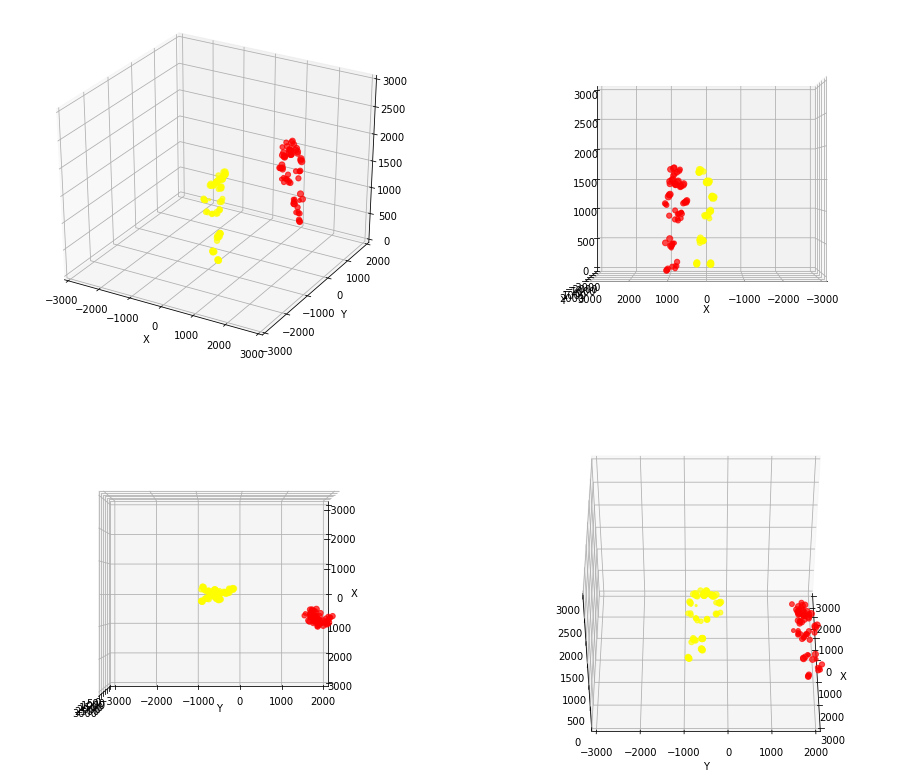

In [4]:
COLORS = cs.lincolor(max(1, len(persons) + 1))/255
fig = plt.figure(figsize=(16,14))
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def plot(ax):
    ax.set_xlim([-3000, 3000])
    ax.set_ylim([-3000, 2000])
    ax.set_zlim([0, 3000])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    for pid, person in enumerate(valid_persons):
        for jid, pts3d in enumerate(person):
            if pts3d is not None:
                X = pts3d[:,0]
                Y = pts3d[:,1]
                Z = pts3d[:,2]
                W1 = pts3d[:,3]
                W2 = pts3d[:,4]

                ax.scatter(X,Y,Z,alpha=0.7, color=COLORS[pid], s=W1*W2*50)

ax = fig.add_subplot(221, projection='3d'); plot(ax)
ax = fig.add_subplot(222, projection='3d'); ax.view_init(0, 90); plot(ax)
ax = fig.add_subplot(223, projection='3d'); ax.view_init(90, 0); plot(ax)
ax = fig.add_subplot(224, projection='3d'); ax.view_init(45, 0); plot(ax)

plt.show()

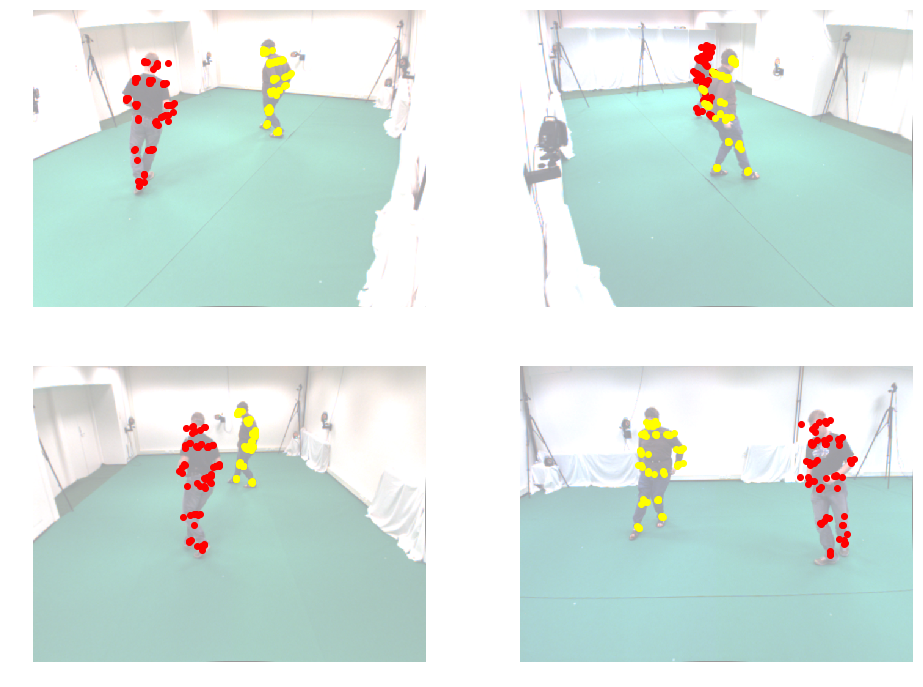

In [5]:
fig = plt.figure(figsize=(16,12))

for cid, cam in enumerate(Gr.Calib_undistorted):
    ax = fig.add_subplot(2 if USE_UMPM else 3,2 if USE_UMPM else 3,1+cid)
    ax.set_xlim([0, 644])
    ax.set_ylim([486, 0])
    ax.axis('off')
    im = Im[cid]
    mapx, mapy = Gr.undistort_maps[cid]
    im = cv2.remap(im, mapx, mapy, interpolation=cv2.INTER_LINEAR)
    ax.imshow(im, alpha=0.4)
    
    for pid, person in enumerate(valid_persons):
        for jid, pts3d in enumerate(person):
            if pts3d is not None:
                Pt = pts3d[:,0:3].astype('float32')
                W1 = pts3d[:,3]
                W2 = pts3d[:,4]
                K, rvec, tvec, _ = gm.get_camera_parameters(cam)
                points2d = np.squeeze(cv2.projectPoints(Pt, rvec, tvec, K, 0)[0])
                if len(points2d.shape) == 1:
                    points2d = np.expand_dims(points2d, axis=0)
                ax.scatter(points2d[:,0], points2d[:,1], 
                           color=COLORS[pid])
    
plt.show()

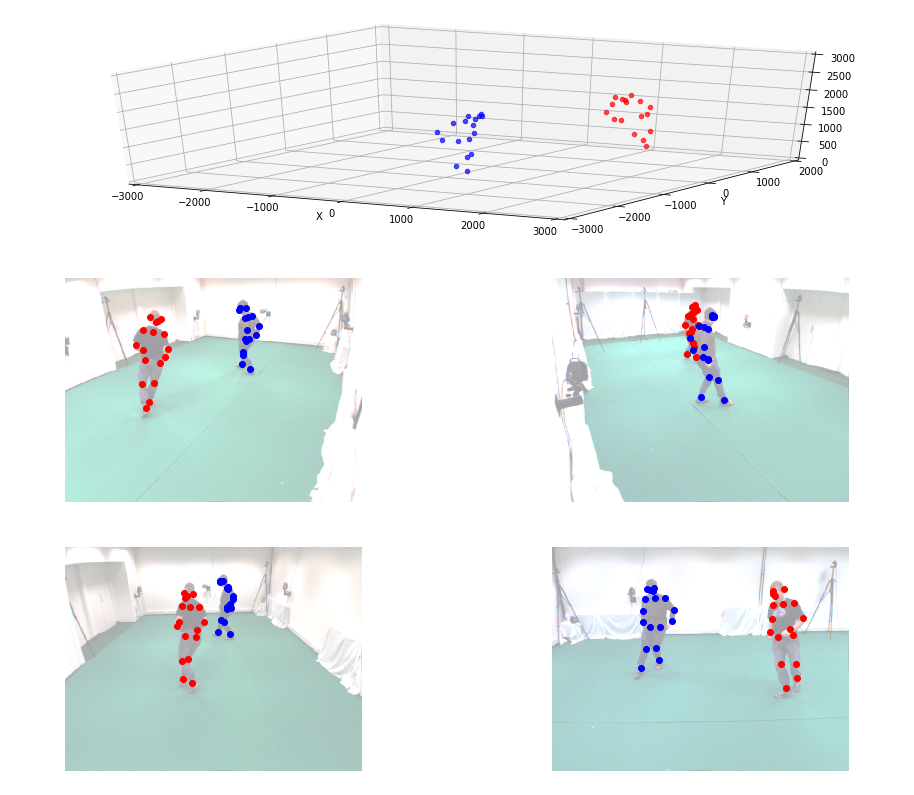

In [6]:
def merge(person):
    result = [None] * len(person)
    for jid, points3d in enumerate(person):
        if points3d is not None:
            Pos = points3d[:,0:3]
            W = np.expand_dims(points3d[:,3] * points3d[:,4], axis=1)
            S = np.sum(W)
            WPos = np.multiply(Pos, W)
            WPos = np.sum(WPos, axis=0)/S
            result[jid] = WPos
    return result

Humans = [merge(p) for p in valid_persons]

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

COLORS = cs.lincolor(max(1, len(persons) + 1))/255
COLORS = ['red', 'blue', 'green', 'pink', 'teal', 'orange', 'gray']
fig = plt.figure(figsize=(16,14))
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def plot(ax):
    ax.set_xlim([-3000, 3000])
    ax.set_ylim([-3000, 2000])
    ax.set_zlim([0, 3000])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    for pid, person in enumerate(Humans):
        for jid, pts3d in enumerate(person):
            if pts3d is not None:
                X = pts3d[0]
                Y = pts3d[1]
                Z = pts3d[2]

                ax.scatter(X,Y,Z,alpha=0.7, color=COLORS[pid])

ax = fig.add_subplot(311, projection='3d'); plot(ax)

# ========================================================
def project_human_to_2d(human3d, cam):
    human2d = [None] * len(human3d)
    for jid, pt3d in enumerate(human3d):
        if pt3d is not None:
            Pt = np.array([pt3d])
            K, rvec, tvec, _ = gm.get_camera_parameters(cam)
            points2d = np.squeeze(cv2.projectPoints(Pt, rvec, tvec, K, 0)[0])
            human2d[jid] = points2d
    return human2d
# ========================================================        

for cid, cam in enumerate(Gr.Calib_undistorted):
    skip = 3 if USE_UMPM else 4
    ax = fig.add_subplot(3 if USE_UMPM else 4,2 if USE_UMPM else 3,skip+cid)
    ax.set_xlim([0, 644])
    ax.set_ylim([486, 0])
    ax.axis('off')
    im = Im[cid]
    mapx, mapy = Gr.undistort_maps[cid]
    im = cv2.remap(im, mapx, mapy, interpolation=cv2.INTER_LINEAR)
    ax.imshow(im, alpha=0.4)
    
    for pid, person in enumerate(Humans):
        human2d = project_human_to_2d(person, cam)
        for point2d in human2d:
            if point2d is None:
                continue
            ax.scatter(point2d[0], point2d[1], 
                            color=COLORS[pid])

plt.show()

## Prevent Ghosting

Ghosts show up due to ambiguitiy in at least two frames where persons yield similar pose from different perspectives. To tackle the problem, a heuristic is used to remove the unwanted detection:

* If a person is identity-switching 
* If a person has low scores on the heatmaps for more than 1 image

In [7]:
import numpy.linalg as la

hm_detection_threshold = 0.1
threshold_close_pair = 10  # in pixels
print('min #joints:', min_nbr_joints)

def calculate2d_proximity(person1, person2):
    n_joints = len(person1)
    assert n_joints == len(person2)
    jointwise_proximity = [-1] * n_joints
    
    for jid, (pt1, pt2) in enumerate(zip(person1, person2)):
        if pt1 is not None and pt2 is not None:
            distance = la.norm(pt1 - pt2)
            jointwise_proximity[jid] = distance
    return jointwise_proximity


n = len(Humans)
n_cams = len(Gr.Calib_undistorted)

# -1 -> not visible
#  0 -> not in frame
#  1 -> visible
#  2 -> collision
FLAG_NOT_VISIBLE = -1
FLAG_VISIBLE = 1
FLAG_COLLISION = 2
Visibility_Table = np.zeros((n_cams, n))

for a in range(n):
    human3d_a = Humans[a]
    n_joints = len(human3d_a)
    count_visible_in_camera = 0
    for cid, cam in enumerate(Gr.Calib_undistorted):
        human2d_a = project_human_to_2d(human3d_a, cam)
        # ==============================================
        # check in how many views two persons co-incide
        # ==============================================
        for b in range(a+1, n):
            human3d_b = Humans[b]
            human2d_b = project_human_to_2d(human3d_b, cam)

            # check if co-incide
            distance = calculate2d_proximity(human2d_a, human2d_b)
            count_close_pairs = 0
            for d in distance:
                if d < 0:
                    continue
                if d < threshold_close_pair:
                    count_close_pairs += 1
            
            if count_close_pairs > min_nbr_joints:
                Visibility_Table[cid, a] = FLAG_COLLISION
                Visibility_Table[cid, b] = FLAG_COLLISION
                
        # ==============================================
        # check the heatmap values in all views
        # ==============================================
        hm = heatmaps[cid]
        h,w,_ = hm.shape
        believe = [-1] * n_joints
        for jid, pt2d in enumerate(human2d_a):
            if pt2d is not None:
                x, y = np.around(pt2d).astype('int32')
                if x > 0 and y > 0 and x < w and y < h:
                    score = hm[y,x,jid]
                    believe[jid] = score
        
        #print(believe)
        total = np.sum((np.array(believe) > hm_detection_threshold))
        if total > min_nbr_joints:
            Visibility_Table[cid, a] = max(FLAG_VISIBLE, Visibility_Table[cid, a])
        else:
            Visibility_Table[cid, a] = FLAG_NOT_VISIBLE


Valid_Humans = []
for human3d, visibility_in_cams in zip(Humans, np.transpose(Visibility_Table)):
    valid_cams = np.sum(visibility_in_cams == 1)
    if valid_cams > 1:  # valid in at least 2 views
        Valid_Humans.append(human3d)

min #joints: 8


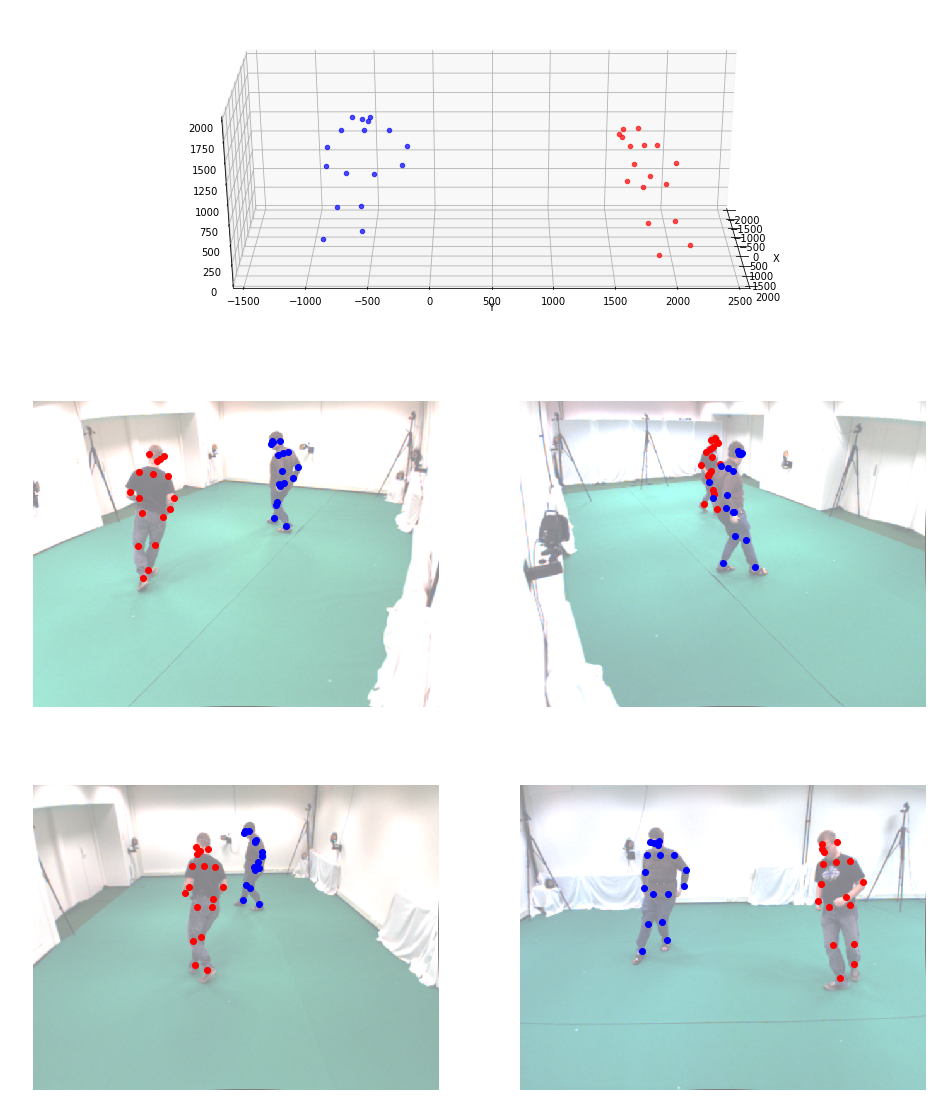

In [13]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

COLORS = cs.lincolor(max(1, len(persons) + 3))/255
COLORS = ['red', 'blue', 'green']
fig = plt.figure(figsize=(16,20))
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def plot(ax):
    ax.set_xlim([-2000, 2000])
    ax.set_ylim([-1500, 2500])
    ax.set_zlim([0, 2000])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    for pid, person in enumerate(Valid_Humans):
        for jid, pts3d in enumerate(person):
            if pts3d is not None:
                X = pts3d[0]
                Y = pts3d[1]
                Z = pts3d[2]
                ax.scatter(X,Y,Z,alpha=0.7, color=COLORS[pid])

ax = fig.add_subplot(311, projection='3d'); plot(ax)
ax.view_init(24, 0)

# ========================================================
def project_human_to_2d(human3d, cam):
    human2d = [None] * len(human3d)
    for jid, pt3d in enumerate(human3d):
        if pt3d is not None:
            Pt = np.array([pt3d])
            K, rvec, tvec, _ = gm.get_camera_parameters(cam)
            points2d = np.squeeze(cv2.projectPoints(Pt, rvec, tvec, K, 0)[0])
            human2d[jid] = points2d
    return human2d
# ========================================================        

for cid, cam in enumerate(Gr.Calib_undistorted):
    skip = 3 if USE_UMPM else 4
    ax = fig.add_subplot(3 if USE_UMPM else 4,2 if USE_UMPM else 3,skip+cid)
    ax.set_xlim([0, 644])
    ax.set_ylim([486, 0])
    ax.axis('off')
    im = Im[cid]
    mapx, mapy = Gr.undistort_maps[cid]
    im = cv2.remap(im, mapx, mapy, interpolation=cv2.INTER_LINEAR)
    ax.imshow(im, alpha=0.5)
    
    for pid, person in enumerate(Valid_Humans):
        human2d = project_human_to_2d(person, cam)
        for point2d in human2d:
            if point2d is None:
                continue
            ax.scatter(point2d[0], point2d[1], 
                            color=COLORS[pid])

plt.show()